<a href="https://colab.research.google.com/github/MattBaudoin/SCMT610_GroupProject/blob/dev/Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 1

* **Matthew Baudoin** -
* **Kevin Brown** -
* **Chelsea Jacobo** -
* **Grace Morris** -
* **Stephie Noel** -
* **Kal Zapotocky** -







Our objective is to use text analytics to link customer language in online reviews to
satisfaction outcomes, enabling firms to identify early indicators of dissatisfaction,
diagnose operational weaknesses, and prioritize targeted service improvements.

1. Can the language used in Yelp reviews predict whether a customer will leave a low
satisfaction rating (1-2 stars)?
2. Which recurring themes or language patterns in customer reviews are most strongly
associated with low satisfaction ratings?
3. Do the language patterns associated with negative reviews differ across business
categories or geographic locations, suggesting the need for category or location-specific
service interventions?

Group Project Part B Objectives:
1) Build a Latent Dirichlet Allocation (LDA) topic model (Steps 12-14)
2) build a data frame that shows the keywords associated with each document (e.g., review) and the dominant topic along with its percentage contribution to each document. (Steps 15-16)

# NOTE: Our Kaggle dataset did not come with any source code, so everything was written from scratch.

# **Environment Setup: If you are in Google Colab, run steps 1-3 and then skip to step 5**


# **Environment Setup: If you are on a local IDE, run steps 2, 4, 5.**

In [69]:
#1 - Environment setup: Connect Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [118]:
#2 - Environment setup: load dependencies & NLP Setup

from collections import Counter, defaultdict
from pathlib import Path
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import roc_auc_score
import string
import time
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def ensure_nltk_resource(resource):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource.split("/")[-1])

In [123]:
#3 - Configuration: Paths: In Colab

BASE_DIR = Path("/content/drive/Shared drives/Team1Share/GroupProject")

# Source + derived datasets
SLIM_PARQUET_DIR = BASE_DIR / "reviews_slim"          # slimmed raw reviews (parquet parts)
TEXT_CLEAN_CHUNK_DIR = BASE_DIR / "reviews_text_clean" # cleaned review chunks (parquet)
LDA_OUT_DIR = BASE_DIR / "lda_outputs"

# ---- Validation (do NOT create data dirs here; fail fast if missing) ----
assert BASE_DIR.exists(), f"Missing BASE_DIR: {BASE_DIR}"
assert SLIM_PARQUET_DIR.exists(), f"Missing SLIM_PARQUET_DIR: {SLIM_PARQUET_DIR}"
assert TEXT_CLEAN_CHUNK_DIR.exists(), f"Missing TEXT_CLEAN_CHUNK_DIR: {TEXT_CLEAN_CHUNK_DIR}"
assert LDA_OUT_DIR.exists(), f"Missing LDA_OUT_DIR: {LDA_OUT_DIR}"

print("Configuration validated")
print("BASE_DIR:", BASE_DIR)

Configuration validated
BASE_DIR: /content/drive/Shared drives/Team1Share/GroupProject
SLIM_PARQUET_DIR: /content/drive/Shared drives/Team1Share/GroupProject/reviews_slim
TEXT_CLEAN_CHUNK_DIR: /content/drive/Shared drives/Team1Share/GroupProject/reviews_text_clean
LDA_OUT_DIR: /content/drive/Shared drives/Team1Share/GroupProject/lda_outputs


# **Run step 4 only if you are working in an IDE with dataset on local machine.**

In [ ]:
#4 - Configuration: Paths: On Desktop

# This works as long as your project file is in the same folder as your dataset folders.

BASE_DIR = Path.cwd()

# Source + derived datasets
SLIM_PARQUET_DIR = BASE_DIR / "reviews_slim"          # slimmed raw reviews (parquet parts)
TEXT_CLEAN_CHUNK_DIR = BASE_DIR / "reviews_text_clean" # cleaned review chunks (parquet)
LDA_OUT_DIR = BASE_DIR / "lda_outputs"

# ---- Validation (do NOT create data dirs here; fail fast if missing) ----
assert BASE_DIR.exists(), f"Missing BASE_DIR: {BASE_DIR}"
assert SLIM_PARQUET_DIR.exists(), f"Missing SLIM_PARQUET_DIR: {SLIM_PARQUET_DIR}"
assert TEXT_CLEAN_CHUNK_DIR.exists(), f"Missing TEXT_CLEAN_CHUNK_DIR: {TEXT_CLEAN_CHUNK_DIR}"
assert LDA_OUT_DIR.exists(), f"Missing LDA_OUT_DIR: {LDA_OUT_DIR}"

print("Configuration validated")
print("BASE_DIR:", BASE_DIR)
print("SLIM_PARQUET_DIR:", SLIM_PARQUET_DIR)
print("TEXT_CLEAN_CHUNK_DIR:", TEXT_CLEAN_CHUNK_DIR)
print("LDA_OUT_DIR:", LDA_OUT_DIR)

AssertionError: Dataset not found: /content/Yelp_Dataset/yelp_academic_dataset_review.json

# **We don't need to run these again. Steps 6-8 are the steps we took to clean our raw dataset.**

# If you're working on LDA, skip to step 9

In [72]:
#5 - NLTK setup

# NTLK resources + stopwords/lemmatizer

ensure_nltk_resource("corpora/stopwords")
ensure_nltk_resource("corpora/wordnet")
ensure_nltk_resource("corpora/omw-1.4")

stop_words = set(stopwords.words("english"))

# Keep negations (critical for sentiment / low-satisfaction language)
NEGATIONS = {"no", "not", "nor", "never", "n't"}
stop_words = stop_words - NEGATIONS

# Drop numeric placeholder token used in pipeline
stop_words = stop_words | {"num_token"}

lemmatizer = WordNetLemmatizer()

print(f"Stopwords loaded: {len(stop_words)} (negations kept)")

Stopwords loaded: 196 (negations kept)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#6 - Basic quality cleanup and text cleaning functions

# Precompile regex once (faster)
RE_URL_EMAIL = re.compile(r"http\S+|www\.\S+|\S+@\S+")
RE_NBSP_HTML = re.compile(r"&nbsp;")
RE_WS = re.compile(r"\s+")
RE_ELONG = re.compile(r"(.)\1{2,}")          # soooo -> soo
RE_NUM = re.compile(r"\d+")
RE_PUNCT_KEEP_HYPHEN = re.compile(r"[^\w\s\-]")  # remove punctuation but keep hyphen
RE_APOSTROPHE = re.compile(r"[’`´]")         # normalize weird apostrophes to '

# Contractions (simple, good-enough starter list)
CONTRACTIONS = {
    "can't": "can not",
    "won't": "will not",
    "n't": " not",
    "i'm": "i am",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mustn't": "must not",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "i've": "i have",
    "we've": "we have",
    "they've": "they have",
    "i'll": "i will",
    "we'll": "we will",
    "they'll": "they will",
    "she's": "she is",
    "he's": "he is",

}
# Build a regex that matches keys like "can't", "won't", etc.
RE_CONTRACTIONS = re.compile(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b")

def expand_contractions(text: str) -> str:
    # normalize apostrophes first
    text = RE_APOSTROPHE.sub("'", text)
    return RE_CONTRACTIONS.sub(lambda m: CONTRACTIONS[m.group(0)], text)

def reduce_character_noise(token: str) -> str:
    return RE_ELONG.sub(r"\1\1", token)

def clean_review_text_method(text: str) -> str:
    # 1) Ensure string + Unicode normalize (keeps accents but normalizes representation)
    text = "" if text is None else str(text)
    text = unicodedata.normalize("NFKC", text)

    # 2) Normalize NBSP and whitespace-ish artifacts
    text = text.replace("\u00A0", " ")      # actual NBSP char
    text = RE_NBSP_HTML.sub(" ", text)      # literal &nbsp; if present

    # 3) Lowercase
    text = text.lower()

    # 4) Remove URLs/emails
    text = RE_URL_EMAIL.sub(" ", text)

    # 5) Expand contractions BEFORE tokenization
    text = expand_contractions(text)

    # 6) Normalize numbers to a token
    text = RE_NUM.sub(" num_token ", text)

    # 7) Punctuation policy:
    #    - remove punctuation except hyphens
    #    - then split hyphens to spaces (wait-time -> wait time)
    text = RE_PUNCT_KEEP_HYPHEN.sub(" ", text)
    text = text.replace("-", " ")

    # 8) Collapse whitespace
    text = RE_WS.sub(" ", text).strip()

    # 9) Tokenize
    tokens = text.split()

    cleaned_tokens = []
    for tok in tokens:
        tok = reduce_character_noise(tok)

        # keep num_token as-is
        if tok == "num_token":
            cleaned_tokens.append(tok)
            continue

        # keep alphabetic tokens that aren't stopwords (negations already preserved in stop_words)
        if tok.isalpha() and tok not in stop_words:
            tok = lemmatizer.lemmatize(tok)
            cleaned_tokens.append(tok)

    return " ".join(cleaned_tokens)

In [ ]:
#7 - Apply cleaning method in manageable chunks
# Output: one cleaned chunk per slim parquet part

LOG_EVERY = 5          # log every N parts
MIN_WORDS = 5          # your post-cleaning minimum (we can tune later)

part_files = sorted(glob.glob(os.path.join(SLIM_PARQUET_DIR, "part_*.parquet")))
total_parts = len(part_files)

# Resume: detect already-written chunks
existing_files = glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet"))
print(f"Total parts to process: {total_parts}")
print(f"Chunks already on disk: {len(existing_files)}")

t0 = time.time()
processed = 0
skipped = 0

for part_idx, part_path in enumerate(part_files):
    chunk_path = os.path.join(TEXT_CLEAN_CHUNK_DIR, f"chunk_{part_idx:05d}.parquet")

    # Resume: skip completed
    if os.path.exists(chunk_path):
        skipped += 1
        continue

    df = pd.read_parquet(part_path, engine="pyarrow")

    # Basic cleanup (per part)
    df["text"] = df["text"].astype("string")
    df = df.dropna(subset=["text"])
    df = df[df["text"].str.strip() != ""]
    df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)  # within-part dedupe

    # Apply cleaning
    df["text_clean"] = df["text"].map(clean_review_text_method)

    # Drop empty after cleaning
    df = df[df["text_clean"].str.strip() != ""]

    # Min word filter (vectorized)
    df["clean_word_count"] = df["text_clean"].str.split().str.len()
    df = df[df["clean_word_count"] >= MIN_WORDS]

    # Keep only needed columns (drop raw text)
    df = df[["review_id", "business_id", "stars", "date", "text_clean"]].reset_index(drop=True)

    # Write checkpoint
    tmp_path = chunk_path + ".tmp"
    df.to_parquet(tmp_path, index=False, compression="snappy", engine="pyarrow")
    os.replace(tmp_path, chunk_path)  # atomic on Windows

    processed += 1

    if processed % LOG_EVERY == 0:
        elapsed = time.time() - t0
        done = part_idx + 1
        pct = 100 * done / total_parts
        rate = done / elapsed if elapsed > 0 else 0
        eta_min = (total_parts - done) / rate / 60 if rate > 0 else float("inf")
        print(f"[{done:>3}/{total_parts}] {pct:>6.2f}% | elapsed {elapsed/60:>6.1f}m | ETA {eta_min:>6.1f}m | wrote {len(df):,} rows")

elapsed = time.time() - t0
print(f"Cleaning complete. processed={processed}, skipped={skipped}, elapsed={elapsed/60:.1f} min")
print("Output:", TEXT_CLEAN_CHUNK_DIR)

Total parts to process: 0
Chunks already on disk: 0
Cleaning complete. processed=0, skipped=0, elapsed=0.0 min
Output: /content/reviews_text_clean


In [ ]:
#8 - Checking the file size of our cleaned database

files = glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet"))
print("Chunk files:", len(files))

if not files:
    print("No chunk files found yet.")
else:
    total_bytes = sum(os.path.getsize(f) for f in files)
    print("Total size (GB):", total_bytes / (1024**3))
    print("Smallest file (MB):", min(os.path.getsize(f) for f in files) / (1024**2))
    print("Largest file (MB):", max(os.path.getsize(f) for f in files) / (1024**2))

Chunk files: 70
Total size (GB): 1.6203952506184578
Smallest file (MB): 22.7324275970459
Largest file (MB): 25.91992950439453


# **Run step 9 to make sure our cleaned dataset is available, then move to step 10 to load the streaming utility that will assist with handling our large dataset size.**

In [66]:
#9 - Post-cleaning validation: confirm cleaned chunk outputs are complete
# - Counts cleaned chunk files and total disk usage
# - Samples a few chunks to verify schema, nulls, stars distribution, text lengths
# - Verifies key cleaning policies (num_token presence, negations retained)
chunk_files = sorted(glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet")))
print("Cleaned chunks found:", len(chunk_files))
assert len(chunk_files) > 0, "No cleaned chunks found."

# Load a few chunks (first, middle, last) for quick checks
sample_idxs = [0, len(chunk_files)//2, len(chunk_files)-1]
dfs = []
for idx in sample_idxs:
    df = pd.read_parquet(chunk_files[idx], engine="pyarrow")
    df["chunk_id"] = idx
    dfs.append(df)

df_check = pd.concat(dfs, ignore_index=True)

print("\nColumns:", df_check.columns.tolist())
print("\nDtypes:\n", df_check.dtypes)

# Basic sanity
print("\nRows sampled:", len(df_check))
print("Nulls:\n", df_check.isna().sum())

# Stars distribution (in sampled chunks)
print("\nStars distribution (sampled chunks):")
print(df_check["stars"].value_counts().sort_index())

# Text length distribution
df_check["clean_words"] = df_check["text_clean"].str.split().str.len()
print("\nClean word count percentiles:")
print(df_check["clean_words"].quantile([0.1, 0.5, 0.9, 0.95, 0.99]))

# Verify policy effects
print("\nnum_token frequency (docs containing it):",
      (df_check["text_clean"].str.contains(r"\bnum_token\b")).mean())

negation_terms = ["not", "no", "never"]
for term in negation_terms:
    frac = (df_check["text_clean"].str.contains(rf"\b{term}\b")).mean()
    print(f"Docs containing '{term}': {frac:.3f}")

# Quick samples
print("\nSample cleaned texts:")
display(df_check[["stars","text_clean"]].head(10))

Cleaned chunks found: 70

Columns: ['review_id', 'business_id', 'stars', 'date', 'text_clean', 'chunk_id']

Dtypes:
 review_id              object
business_id            object
stars                   int64
date           datetime64[us]
text_clean             object
chunk_id                int64
dtype: object

Rows sampled: 290051
Nulls:
 review_id      0
business_id    0
stars          0
date           0
text_clean     0
chunk_id       0
dtype: int64

Stars distribution (sampled chunks):
stars
1     41798
2     22714
3     29837
4     64046
5    131656
Name: count, dtype: int64

Clean word count percentiles:
0.10     15.0
0.50     40.0
0.90    113.0
0.95    149.0
0.99    248.0
Name: clean_words, dtype: float64

num_token frequency (docs containing it): 0.403298040689396
Docs containing 'not': 0.576
Docs containing 'no': 0.161
Docs containing 'never': 0.115

Sample cleaned texts:


,stars,text_clean
0,3,decide eat aware going take num_token hour beg...
1,5,taken lot spin class year nothing compare clas...
2,3,family diner buffet eclectic assortment large ...
3,5,wow yummy different delicious favorite lamb cu...
4,4,cute interior owner gave u tour upcoming patio...
5,1,long term frequent customer establishment went...
6,5,loved tour grabbed groupon price great perfect...
7,5,amazingly amazing wing homemade bleu cheese ri...
8,3,easter instead going lopez lake went los padre...
9,3,party num_token hibachi waitress brought separ...


In [67]:
#10 - Define helpers and utilities

def iter_parquet_chunks(parquet_dir, pattern="chunk_*.parquet", columns=None, engine="pyarrow"):
    parquet_dir = str(parquet_dir)  # allow Path objects
    files = sorted(glob.glob(str(Path(parquet_dir) / pattern)))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {parquet_dir} matching {pattern}")

    for f in files:
        yield f, pd.read_parquet(f, columns=columns, engine=engine)

# **If you've already built an LDA model before and saved it to LDA_OUT_DIR, reload them with step 11, otherwise go to step 12 to fit the model**

In [124]:
#11 - Reload saved LDA outputs

files = [
    "lda_topics.parquet",
    "lda_topic_association.parquet",
    "lda_doc_topics_sample500k.parquet",
]
for fn in files:
    assert (LDA_OUT_DIR / fn).exists(), f"Missing saved output: {LDA_OUT_DIR / fn}"

df_topics = pd.read_parquet(LDA_OUT_DIR / "lda_topics.parquet", engine="pyarrow")
df_topic_assoc = pd.read_parquet(LDA_OUT_DIR / "lda_topic_association.parquet", engine="pyarrow")
df_doc = pd.read_parquet(LDA_OUT_DIR / "lda_doc_topics_sample500k.parquet", engine="pyarrow")

print("Reloaded from:", LDA_OUT_DIR)
print("df_topics:", df_topics.shape)
print("df_topic_assoc:", df_topic_assoc.shape)
print("df_doc:", df_doc.shape)

df_topics.head()

Reloaded from: /content/drive/Shared drives/Team1Share/GroupProject/lda_outputs
df_topics: (20, 2)
df_topic_assoc: (20, 7)
df_doc: (500000, 31)


,topic_id,top_terms
0,0,"great, amazing, recommend, back, service, defi..."
1,1,"not, store, time, like, great, hair, really, a..."
2,2,"not, no, time, one, would, said, back, get, se..."
3,3,"chicken, salad, sauce, ordered, fried, delicio..."
4,4,"car, not, would, day, call, service, called, w..."


# From here we will build a LDA model that shows the keywords associated with each document (Yelp Review) and the dominant topic along with its percentage contribution to each doc.

In [73]:
#12 - Build an LDA training sample
# Iterate cleaned parquet chunks (chunk_*.parquet) from TEXT_CLEAN_CHUNK_DIR
# Read only required columns to minimize I/O and memory
# Accumulate documents until SAMPLE_DOCS is reached

SAMPLE_DOCS = 500_000
MAX_WORDS = 300   # truncate long docs for speed/stability

texts = []
meta = []   # keep ids for downstream doc-topic dataframe

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["review_id", "stars", "business_id", "text_clean"]
):
    remaining = SAMPLE_DOCS - len(texts)
    if remaining <= 0:
        break

    take_n = min(remaining, len(df_part))

    part_texts = (
        df_part["text_clean"]
        .iloc[:take_n]
        .str.split()
        .str[:MAX_WORDS]
        .str.join(" ")
    )

    texts.extend(part_texts.tolist())
    meta.extend(
        df_part.loc[df_part.index[:take_n], ["review_id", "stars", "business_id"]]
        .to_dict("records")
    )

print("LDA sample docs:", len(texts))
print("LDA sample meta rows:", len(meta))
assert len(texts) == len(meta), "texts/meta misalignment"

LDA sample docs: 500000
LDA sample meta rows: 500000


In [74]:
# 13 - Build TF matrix for LDA (count-based document × term matrix)

tf_vectorizer_lda = CountVectorizer(
    max_features=50_000,
    min_df=50,    # (10/20/50/100) Keep a token in vocab only if it appears in >= X documents
    max_df=0.6,  # This is expressed as a %. Exclude the token from vocabulary if it appears in over X% of documents
    ngram_range=(1,2),
    stop_words=stop_words
)

X_tf_lda = tf_vectorizer_lda.fit_transform(texts)

print("X_tf_lda shape:", X_tf_lda.shape)
print("LDA vocab size:", len(tf_vectorizer_lda.vocabulary_))

X_tf_lda shape: (500000, 50000)
LDA vocab size: 50000


In [75]:
# 14 - Fit the LDA model on the TF matrix

# What we're doing:
# - We are asking LDA to find groups of words that tend to appear together.
# - Each group is called a "topic".

# - This helps us summarize reviews into a smaller set of themes (slow service, great food, pricing, cleanliness).

N_TOPICS = 20   # Fit the tokens in our TF matrix into N amount of topics.
                # To judge what the best # of topics to use is, we adjust up/down and review the top words per topic.
                # By raising the # of topics are we getting new themes or do we have duplicates of the same themes?

lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="online", # Uses mini-batch updates, which scales better for large corpora than full batch learning
    batch_size=4096,  # batch_size: number of documents per mini-batch update (increase batch size for speed, decrease if you run into memory issues: 4096 > 2048 > 1024 > 512))
    max_iter=10,  # max_iter: passes over the data (higher = more stable topics, slower)
    random_state=42,  # random_state: reproducibility
    n_jobs=-1, # use all available cores for jobs
    verbose=1,
    evaluate_every=0  # Disables perplexity evaluation
)

doc_topic = lda.fit_transform(X_tf_lda)
print("LDA fit complete. doc_topic shape:", doc_topic.shape)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA fit complete. doc_topic shape: (500000, 20)


In [76]:
#15 - Extract top keywords for each topic

# - After training, each topic has a list of words that best describe it.
# - We print the top N words so we can "name" or interpret the topic.

feature_names = tf_vectorizer_lda.get_feature_names_out()
TOP_N_WORDS = 12

topic_word = lda.components_ / lda.components_.sum(axis=1)[:, None]

topics = []
for topic_id, weights in enumerate(topic_word):  # use normalized
    top_idx = np.argsort(weights)[::-1][:TOP_N_WORDS]
    topics.append({
        "topic_id": topic_id,
        "top_terms": ", ".join(feature_names[i] for i in top_idx)
    })

df_topics = pd.DataFrame(topics).sort_values("topic_id")
df_topics

,topic_id,top_terms
0,0,"great, amazing, recommend, back, service, defi..."
1,1,"not, store, time, like, great, hair, really, a..."
2,2,"not, no, time, one, would, said, back, get, se..."
3,3,"chicken, salad, sauce, ordered, fried, delicio..."
4,4,"car, not, would, day, call, service, called, w..."
5,5,"pizza, order, delivery, ordered, crust, cheese..."
6,6,"coffee, cream, ice, cake, not, flavor, sweet, ..."
7,7,"room, not, hotel, clean, stay, nice, floor, fr..."
8,8,"sandwich, taco, cheese, meat, chip, not, bbq, ..."
9,9,"location, parking, new, st, street, great, tou..."


In [77]:
#16 Build full topic distribution per review (theta) and attach identifiers + topic keywords

# Base document table (ids + labels kept during sampling)
df_doc = pd.DataFrame(meta).copy()
assert len(df_doc) == doc_topic.shape[0]

# Full topic distribution columns
K = doc_topic.shape[1]
topic_cols = [f"topic_{k}" for k in range(K)]
df_doc[topic_cols] = doc_topic.astype("float32")

# Low satisfaction label (for later analysis)
df_doc["low_satisfaction"] = df_doc["stars"].isin([1, 2]).astype(int)

# Dominant topic + its % contribution within the review
df_doc["dominant_topic"] = doc_topic.argmax(axis=1)
df_doc["dominant_topic_pct"] = doc_topic.max(axis=1)

# Second topic (runner-up) + its %
top2 = np.argsort(doc_topic, axis=1)[:, -2:]
df_doc["second_topic"] = top2[:, 0]
df_doc["second_topic_pct"] = doc_topic[np.arange(doc_topic.shape[0]), df_doc["second_topic"]]

# Attach topic keywords (dominant + second) for readability
df_doc = df_doc.merge(
    df_topics.rename(columns={"top_terms": "dominant_topic_keywords"}),
    left_on="dominant_topic", right_on="topic_id", how="left"
).drop(columns=["topic_id"])

df_doc = df_doc.merge(
    df_topics.rename(columns={"top_terms": "second_topic_keywords"}),
    left_on="second_topic", right_on="topic_id", how="left"
).drop(columns=["topic_id"])

# Compact view (one row per review)
df_doc_keywords = df_doc[[
    "review_id", "stars", "business_id",
    "dominant_topic", "dominant_topic_pct", "dominant_topic_keywords",
    "second_topic", "second_topic_pct", "second_topic_keywords"
]].copy()

# Display without business_id
display_cols = [c for c in df_doc_keywords.columns if c != "business_id"]
df_doc_keywords[display_cols].head(10)

,review_id,stars,dominant_topic,dominant_topic_pct,dominant_topic_keywords,second_topic,second_topic_pct,second_topic_keywords
0,KU_O5udG6zpxOg-VcAEodg,3,2,0.334481,"not, no, time, one, would, said, back, get, se...",19,0.282199,"table, food, not, server, came, restaurant, or..."
1,BiTunyQ73aT9WBnpR9DZGw,5,1,0.832638,"not, store, time, like, great, hair, really, a...",7,0.048195,"room, not, hotel, clean, stay, nice, floor, fr..."
2,saUsX_uimxRlCVr67Z4Jig,3,15,0.359002,"food, restaurant, quality, excellent, service,...",12,0.237113,"good, food, really, nice, service, pretty, pla..."
3,AqPFMleE6RsU23_auESxiA,5,3,0.421948,"chicken, salad, sauce, ordered, fried, delicio...",14,0.283649,"not, roll, sushi, like, rice, spicy, noodle, s..."
4,Sx8TMOWLNuJBWer-0pcmoA,4,8,0.472990,"sandwich, taco, cheese, meat, chip, not, bbq, ...",18,0.164557,"bar, beer, burger, drink, great, fry, place, b..."
5,JrIxlS1TzJ-iCu79ul40cQ,1,2,0.453380,"not, no, time, one, would, said, back, get, se...",5,0.169926,"pizza, order, delivery, ordered, crust, cheese..."
6,6AxgBCNX_PNTOxmbRSwcKQ,5,9,0.533693,"location, parking, new, st, street, great, tou...",2,0.155983,"not, no, time, one, would, said, back, get, se..."
7,_ZeMknuYdlQcUqng_Im3yg,5,3,0.348788,"chicken, salad, sauce, ordered, fried, delicio...",0,0.322722,"great, amazing, recommend, back, service, defi..."
8,ZKvDG2sBvHVdF5oBNUOpAQ,3,7,0.356545,"room, not, hotel, clean, stay, nice, floor, fr...",2,0.239973,"not, no, time, one, would, said, back, get, se..."
9,pUycOfUwM8vqX7KjRRhUEA,3,2,0.347619,"not, no, time, one, would, said, back, get, se...",19,0.215545,"table, food, not, server, came, restaurant, or..."


In [80]:
#17 - Topic association analysis: which topics are most overrepresented in low satisfaction?

# Topic probability columns (theta)
topic_cols = [c for c in df_doc.columns if c.startswith("topic_")]

# Masks
low_mask = df_doc["low_satisfaction"] == 1
notlow_mask = df_doc["low_satisfaction"] == 0

# Average topic share (mean theta) in each group
avg_topic_share_low = df_doc.loc[low_mask, topic_cols].mean()
avg_topic_share_notlow = df_doc.loc[notlow_mask, topic_cols].mean()

# Lift + difference
eps = 1e-12
lift_low_over_not_low = (avg_topic_share_low + eps) / (avg_topic_share_notlow + eps)
share_diff_low_minus_not_low = avg_topic_share_low - avg_topic_share_notlow

# Assemble association table
df_topic_assoc = pd.DataFrame({
    "topic_id": [int(c.replace("topic_", "")) for c in topic_cols],
    "avg_topic_share_in_low_satisfaction": avg_topic_share_low.values,
    "avg_topic_share_in_not_low_satisfaction": avg_topic_share_notlow.values,
    "lift_low_over_not_low": lift_low_over_not_low.values,
    "avg_share_diff_low_minus_not_low": share_diff_low_minus_not_low.values
})

# Combined importance score (helps avoid tiny-denominator lift artifacts)
df_topic_assoc["importance_score_lift_x_low_share"] = (
    df_topic_assoc["lift_low_over_not_low"] * df_topic_assoc["avg_topic_share_in_low_satisfaction"]
)

# Attach topic keywords for interpretation
df_topic_assoc = df_topic_assoc.merge(df_topics, on="topic_id", how="left")

# Filter out topics that are too rare in low-satisfaction docs
MIN_LOW_SHARE = 0.01  # tune (e.g., 0.005 / 0.01 / 0.02)
df_topic_assoc_filtered = df_topic_assoc[
    df_topic_assoc["avg_topic_share_in_low_satisfaction"] >= MIN_LOW_SHARE
].copy()

# Sort
df_low_assoc = df_topic_assoc_filtered[
    (df_topic_assoc_filtered["lift_low_over_not_low"] > 1) &
    (df_topic_assoc_filtered["avg_share_diff_low_minus_not_low"] > 0)
].copy()

df_low_assoc = df_low_assoc.sort_values("importance_score_lift_x_low_share", ascending=False)

print("\nTop topics associated with low satisfaction (filtered):")
display(df_low_assoc.head(10))


Top topics associated with low satisfaction (filtered):


,topic_id,avg_topic_share_in_low_satisfaction,avg_topic_share_in_not_low_satisfaction,lift_low_over_not_low,avg_share_diff_low_minus_not_low,importance_score_lift_x_low_share,top_terms
2,2,0.343682,0.051736,6.642982,0.291946,2.283072,"not, no, time, one, would, said, back, get, se..."
4,4,0.071616,0.035217,2.033573,0.036399,0.145637,"car, not, would, day, call, service, called, w..."
10,10,0.092195,0.062211,1.481972,0.029984,0.136631,"not, place, go, like, would, food, review, get..."
19,19,0.084111,0.060692,1.385880,0.023420,0.116568,"table, food, not, server, came, restaurant, or..."
7,7,0.043456,0.034370,1.264373,0.009086,0.054945,"room, not, hotel, clean, stay, nice, floor, fr..."
5,5,0.022854,0.017750,1.287587,0.005105,0.029427,"pizza, order, delivery, ordered, crust, cheese..."
16,16,0.014446,0.014422,1.001653,0.000024,0.014470,"kid, dog, old, buffet, night, child, family, s..."


In [125]:
#18 - I'm still trying to find an answer to ""How well does a topic predict low satisfaction?""
# In other words, if a review has a high share of a given topic, does that reliably increase the probability that the review is 1–2 stars?

topic_cols = [c for c in df_doc.columns if c.startswith("topic_")]
y = df_doc["low_satisfaction"].astype(int).to_numpy()

rows = []
for c in topic_cols:
    x = df_doc[c].to_numpy()
    auc = roc_auc_score(y, x)
    rows.append({"topic_id": int(c.replace("topic_", "")), "auc": auc})

df_topic_auc = pd.DataFrame(rows).merge(df_topics, on="topic_id", how="left")
df_topic_auc["auc_strength"] = df_topic_auc["auc"].apply(lambda a: max(a, 1-a))
df_topic_auc = df_topic_auc.sort_values("auc_strength", ascending=False)

df_topic_auc.head(10)

,topic_id,auc,top_terms,auc_strength
2,2,0.874129,"not, no, time, one, would, said, back, get, se...",0.874129
0,0,0.275081,"great, amazing, recommend, back, service, defi...",0.724919
17,17,0.312358,"great, always, love, place, food, favorite, ti...",0.687642
12,12,0.338249,"good, food, really, nice, service, pretty, pla...",0.661751
6,6,0.360831,"coffee, cream, ice, cake, not, flavor, sweet, ...",0.639169
9,9,0.379792,"location, parking, new, st, street, great, tou...",0.620208
15,15,0.393375,"food, restaurant, quality, excellent, service,...",0.606625
18,18,0.394405,"bar, beer, burger, drink, great, fry, place, b...",0.605595
8,8,0.394773,"sandwich, taco, cheese, meat, chip, not, bbq, ...",0.605227
3,3,0.406953,"chicken, salad, sauce, ordered, fried, delicio...",0.593047


In [121]:
#19 - Combine accosiation and predictiveness

df_report = (
    df_low_assoc[["topic_id", "lift_low_over_not_low", "avg_topic_share_in_low_satisfaction", "top_terms"]]
    .merge(df_topic_auc[["topic_id", "auc", "auc_strength"]], on="topic_id", how="left")
    .sort_values("lift_low_over_not_low", ascending=False)
)
df_report

,topic_id,lift_low_over_not_low,avg_topic_share_in_low_satisfaction,top_terms,auc,auc_strength
0,2,6.642982,0.343682,"not, no, time, one, would, said, back, get, se...",0.874129,0.874129
1,4,2.033573,0.071616,"car, not, would, day, call, service, called, w...",0.533059,0.533059
2,10,1.481972,0.092195,"not, place, go, like, would, food, review, get...",0.525193,0.525193
3,19,1.385880,0.084111,"table, food, not, server, came, restaurant, or...",0.499770,0.500230
5,5,1.287587,0.022854,"pizza, order, delivery, ordered, crust, cheese...",0.478412,0.521588
4,7,1.264373,0.043456,"room, not, hotel, clean, stay, nice, floor, fr...",0.466726,0.533274
6,16,1.001653,0.014446,"kid, dog, old, buffet, night, child, family, s...",0.464533,0.535467


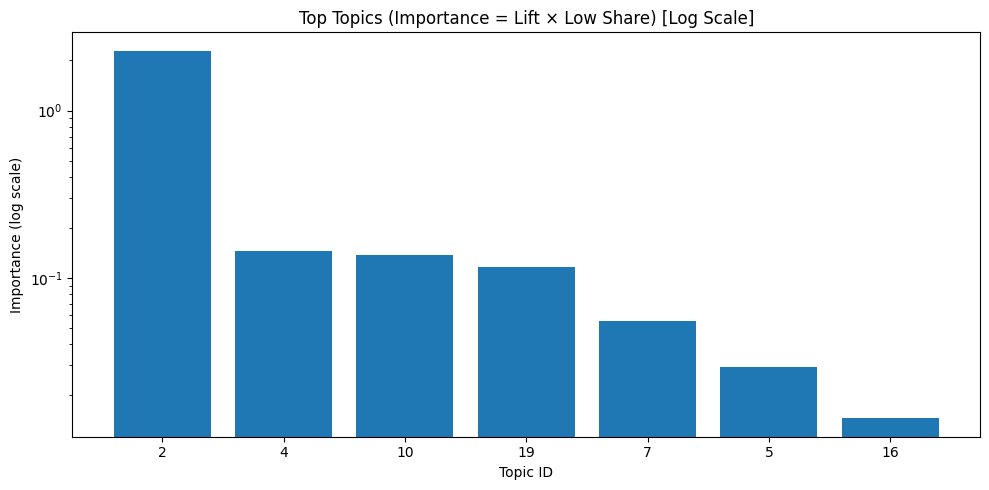

Topic 2 | importance=2.283 | lift=6.64 | low_share=0.344 | not, no, time, one, would, said, back, get, service, never, order, told
Topic 4 | importance=0.146 | lift=2.03 | low_share=0.072 | car, not, would, day, call, service, called, work, company, new, time, office
Topic 10 | importance=0.137 | lift=1.48 | low_share=0.092 | not, place, go, like, would, food, review, get, star, better, thing, bad
Topic 19 | importance=0.117 | lift=1.39 | low_share=0.084 | table, food, not, server, came, restaurant, ordered, time, menu, dinner, meal, night
Topic 7 | importance=0.055 | lift=1.26 | low_share=0.043 | room, not, hotel, clean, stay, nice, floor, front, night, like, bathroom, staff
Topic 5 | importance=0.029 | lift=1.29 | low_share=0.023 | pizza, order, delivery, ordered, crust, cheese, not, wing, slice, topping, good, sauce
Topic 16 | importance=0.014 | lift=1.00 | low_share=0.014 | kid, dog, old, buffet, night, child, family, saturday, son, year, open, pm


In [126]:
#20 Bar chart: Top 10 topics most associated with low satisfaction (importance = lift × low share)

top_n = 10
top = (
    df_low_assoc
    .sort_values("importance_score_lift_x_low_share", ascending=False)
    .head(top_n)
    .copy()
)

plt.figure(figsize=(10,5))
plt.bar(top["topic_id"].astype(str), top["importance_score_lift_x_low_share"])
plt.yscale("log")
plt.title("Top Topics (Importance = Lift × Low Share) [Log Scale]")
plt.xlabel("Topic ID")
plt.ylabel("Importance (log scale)")
plt.tight_layout()
plt.show()

for _, r in top.iterrows():
    print(
        f"Topic {int(r['topic_id'])} | "
        f"importance={r['importance_score_lift_x_low_share']:.3f} | "
        f"lift={r['lift_low_over_not_low']:.2f} | "
        f"low_share={r['avg_topic_share_in_low_satisfaction']:.3f} | "
        f"{r['top_terms']}"
    )

 Looking at the bar chart above, we can infer that:
*   Topics 2 and 4 are strong signals of low satisfaction.
*   Topics 19 and 10 are moderate signals of low satisfaction.
*   Topics 7 and 5 are mild signals; they still skew toward low ratings, but less strongly than the topics above.






In [87]:
#21 Adding in text data to determine the theme of topics

assert len(texts) == len(df_doc), "texts must align 1:1 with df_doc/meta"
df_doc["text_clean"] = texts

In [113]:
#22 Identifying theme of topic

def top_docs_for_topic(df_doc, topic_id, n=10, clip=250):
    out = df_doc.sort_values(f"topic_{topic_id}", ascending=False).head(n).copy()
    out["text_snip"] = out["text_clean"].astype(str).str.slice(0, clip)
    return out[["review_id", "stars", f"topic_{topic_id}", "text_snip",
                "dominant_topic", "dominant_topic_keywords"]]

#top_docs_for_topic(df_doc[df_doc["low_satisfaction"] == 1], 2, n=10)
#top_docs_for_topic(df_doc[df_doc["low_satisfaction"] == 1], 4, n=10)
#top_docs_for_topic(df_doc[df_doc["low_satisfaction"] == 1], 10, n=10)
#top_docs_for_topic(df_doc[df_doc["low_satisfaction"] == 1], 19, n=10)
#top_docs_for_topic(df_doc[df_doc["low_satisfaction"] == 1], 7, n=10)
#top_docs_for_topic(df_doc[df_doc["low_satisfaction"] == 1], 5, n=10)


,review_id,stars,topic_5,text_snip,dominant_topic,dominant_topic_keywords
20459,tr5LyvmMLdD9iTzv3myJHA,2,0.962000,got large cheese pizza delivery pizza crust so...,5,"pizza, order, delivery, ordered, crust, cheese..."
28853,EyIwnHBxjREFT8xldKkUrg,1,0.936667,delivery late pizza garlic knot cold disappoin...,5,"pizza, order, delivery, ordered, crust, cheese..."
233611,UJPhBjU8l0Hwfe5XuOcMTg,1,0.920833,dough cooked plain tasting pizza not repeat di...,5,"pizza, order, delivery, ordered, crust, cheese..."
89210,LvfRjfLIC_tp1k5D-jj6TA,1,0.920833,awful weak thin crust cheese topping falling t...,5,"pizza, order, delivery, ordered, crust, cheese..."
362102,2gnCobhxg6xfz23SCSc8vA,1,0.875131,ordered large pizza thin crust double cheese m...,5,"pizza, order, delivery, ordered, crust, cheese..."
51605,UEyreMB9uLAX1fnwFej8Ig,1,0.864286,forget pizza need cheese sauce,5,"pizza, order, delivery, ordered, crust, cheese..."
135645,qb2L4-MloK1vFdCC1_FrhQ,1,0.854785,terrible pizza priced num_token large thin cru...,5,"pizza, order, delivery, ordered, crust, cheese..."
223675,qSYDGn9l2S_mD84UTmym0g,1,0.853085,nothing like usual tomato pie normal thin crus...,5,"pizza, order, delivery, ordered, crust, cheese..."
240662,5LObopjYOJ_95FH_i0mP1w,2,0.828228,topping sparse mushroom spinach pizza way grea...,5,"pizza, order, delivery, ordered, crust, cheese..."
482647,92vf2umf4A5X-wbJ0vgfcA,2,0.813694,ordered pepperoni pizza doordash no cheese yes...,5,"pizza, order, delivery, ordered, crust, cheese..."


*   Topic 2: Customer service failure
*   Topic 4: Service/repair coordination issues
*   Topic 10: Disappointing food quality
*   Topic 19: Slow table service / long wait times
*   Topic 7: Hotel room conditions
*   Topic 5: Pizza fulfillment & quality


In [114]:
#23 - Save outputs

LDA_OUT_DIR.mkdir(parents=True, exist_ok=True)

df_topics.to_parquet(LDA_OUT_DIR / "lda_topics.parquet", index=False)
df_topic_assoc.to_parquet(LDA_OUT_DIR / "lda_topic_association.parquet", index=False)
df_doc.to_parquet(LDA_OUT_DIR / "lda_doc_topics_sample500k.parquet", index=False)

print("Saved to:", LDA_OUT_DIR)

Saved to: /content/drive/Shared drives/Team1Share/GroupProject/lda_outputs
